<h1>Cat and Dog Image Classifier ML Python Project</h1>

In [1]:
# imports the required libraries

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

2024-03-15 14:02:48.261263: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 14:02:48.402705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 14:02:48.402756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 14:02:48.421249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 14:02:48.471170: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 14:02:48.472346: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [41]:
# downloads the data and sets key variables

# Get project files 
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

--2024-03-15 14:56:18--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.2’

cats_and_dogs.zip.2 100%[===================>]  67,43M  19,6MB/s    in 5,1s    

2024-03-15 14:56:29 (13,2 MB/s) - ‘cats_and_dogs.zip.2’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [49]:
# Variables for pre-processing and training.
batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [43]:
# 3

# create ImageDataGenerator instances for each dataset

# decode the images and convert them into floaint point tensors (between 0 and 1)
train_image_generator = ImageDataGenerator(rescale = 1. / 255) 
validation_image_generator = ImageDataGenerator(rescale = 1. / 255)
test_image_generator = ImageDataGenerator(rescale = 1. / 255)

# preprocessing data for training, validation and test (reading the images)
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size, target_size = (IMG_HEIGHT, IMG_WIDTH), shuffle = True, directory = train_dir, class_mode = 'binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size = batch_size, target_size = (IMG_HEIGHT, IMG_WIDTH), directory = validation_dir, class_mode = 'binary')
test_data_gen = test_image_generator.flow_from_directory(batch_size = batch_size, target_size = (IMG_HEIGHT, IMG_WIDTH), shuffle = False, directory = './cats_and_dogs', classes = ['test'], class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


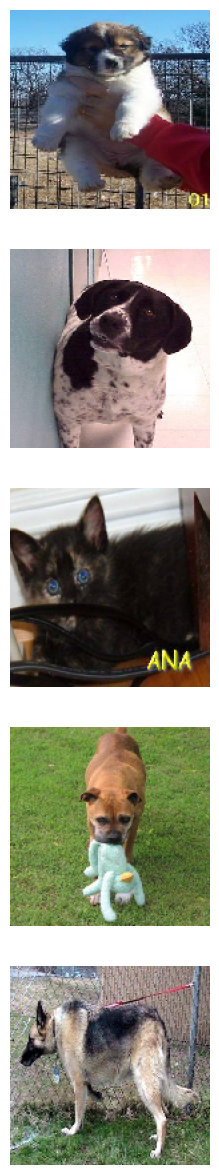

In [44]:
# 4 

# plot five random training images

def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [45]:
# 5

# creating more training data from existing training examples by using random transformation avoiding overfiting
train_image_generator = ImageDataGenerator(rescale = 1. / 255, 
                                           rotation_range = 0.5,
                                           zoom_range = 0.1,
                                           brightness_range = (0.2, 0.4),
                                           shear_range = 2,
                                           channel_shift_range = 3
                                           )

Found 2000 images belonging to 2 classes.


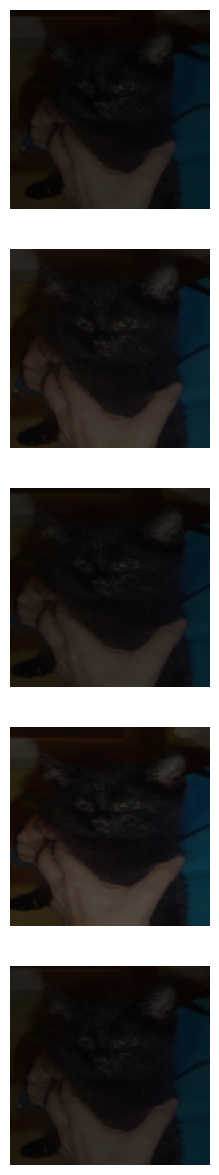

In [46]:
# 6

# single image is plotted five different times using different variations from the new train_image_generator
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [47]:
# 7

# creating a model for the neural network that outputs class probabilities

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 73, 73, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 341056)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               43655296  
                                                      

In [51]:
# 8

# training the model (steps_per_epochs = training data size / batch_size, validation_steps = validation data size / batch_size)

history = model.fit(x = train_data_gen, steps_per_epoch = 15, epochs = epochs, validation_data = val_data_gen, validation_steps = 7)

Epoch 1/10
15/15 [==============================] - 52s 3s/step - loss: 0.6456 - accuracy: 0.6111 - val_loss: 1.0312 - val_accuracy: 0.5022
Epoch 2/10
15/15 [==============================] - 53s 3s/step - loss: 0.6491 - accuracy: 0.5972 - val_loss: 0.7036 - val_accuracy: 0.5770
Epoch 3/10
15/15 [==============================] - 53s 4s/step - loss: 0.6220 - accuracy: 0.6442 - val_loss: 0.7033 - val_accuracy: 0.6016
Epoch 4/10
15/15 [==============================] - 52s 3s/step - loss: 0.6008 - accuracy: 0.6752 - val_loss: 0.6781 - val_accuracy: 0.6451
Epoch 5/10
15/15 [==============================] - 52s 3s/step - loss: 0.5873 - accuracy: 0.7019 - val_loss: 0.7702 - val_accuracy: 0.6205
Epoch 6/10
15/15 [==============================] - 52s 3s/step - loss: 0.5521 - accuracy: 0.7265 - val_loss: 0.9451 - val_accuracy: 0.6205
Epoch 7/10
15/15 [==============================] - 53s 4s/step - loss: 0.5391 - accuracy: 0.7370 - val_loss: 0.7862 - val_accuracy: 0.6406
Epoch 8/10
15/15 [==

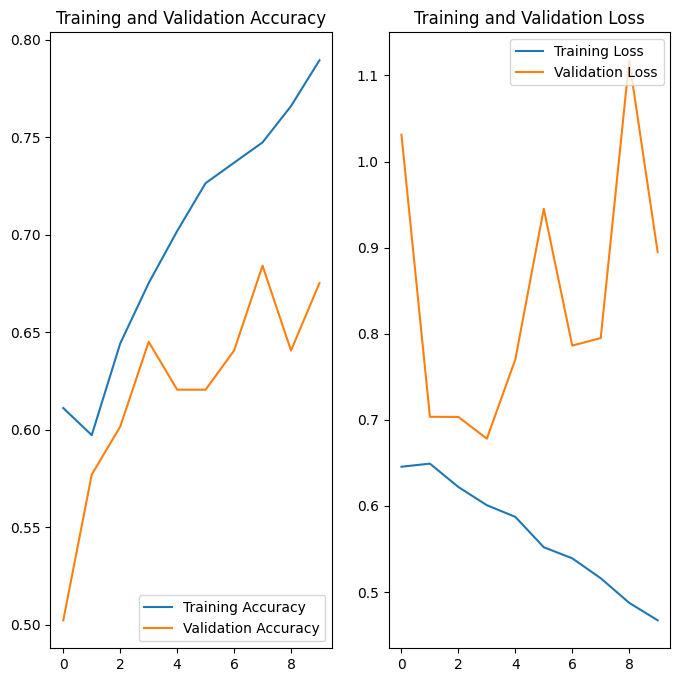

{'loss': [0.6455514430999756, 0.6491194367408752, 0.6219558715820312, 0.6008433699607849, 0.5872883796691895, 0.5520512461662292, 0.5391469597816467, 0.516036331653595, 0.4874882102012634, 0.46720999479293823], 'accuracy': [0.6111111044883728, 0.5972222089767456, 0.6442307829856873, 0.6752136945724487, 0.7019230723381042, 0.7264957427978516, 0.7369791865348816, 0.7473958134651184, 0.7660256624221802, 0.7895299196243286], 'val_loss': [1.031150221824646, 0.7035619616508484, 0.7033323645591736, 0.6781243085861206, 0.7702208757400513, 0.9450762867927551, 0.7862180471420288, 0.794963538646698, 1.1175860166549683, 0.8947417140007019], 'val_accuracy': [0.5022321343421936, 0.5770089030265808, 0.6015625, 0.6450892686843872, 0.6205357313156128, 0.6205357313156128, 0.640625, 0.6841517686843872, 0.640625, 0.6752232313156128]}


In [52]:
# 9

# visualize the accuracy and loss of the model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print(history.history)

1/1 [==============================] - 0s 281ms/step


/tmp/ipykernel_9827/2711790321.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")
/tmp/ipykernel_9827/2711790321.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")


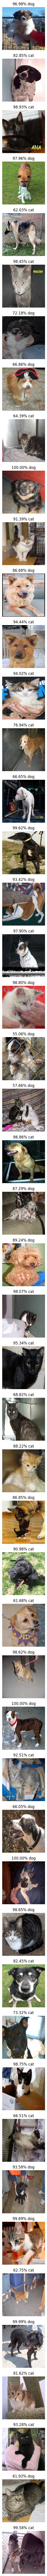

In [53]:
# 10

# use model to predict whether a brand new image is a cat or a dog

probabilities = model.predict(test_data_gen)
plotImages(sample_training_images[:50], probabilities)

In [55]:
# 11

# see if the model passed the test => minimum 63% (this model 68%)
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
